[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hjchoi-infinitt/HandsOnMed_DeepLearning/blob/main/Hands_On_Train.ipynb)

- ##### '파일' -> '드라이브에 사본 저장' 클릭

In [ ]:
# 파이썬에서 경고 메시지를 끄기
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 필요한 라이브러리 설치
!pip install pylibjpeg pylibjpeg-openjpeg pylibjpeg-libjpeg  # GDCM 에러 해결
!pip install pydicom
!pip install albumentations==0.5.2
!pip install pytorch-gradcam
!pip install pillow

In [ ]:
# 코랩에서 한글깨짐 현상 해결 코드
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt # matplotlob import 하기
plt.rcParams['font.family'] = 'NanumBarunGothic' # 나눔바른고딕 적용하기

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [ ]:
# google colab과 google drive 연동 (마운트)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# # /content에 Med_ChatGPT_tutorial 폴더가 생성됨.
!git clone https://github.com/hjchoi-infinitt/HandsOnMed_DeepLearning.git

fatal: destination path 'HandsOnMed_DeepLearning' already exists and is not an empty directory.


In [ ]:
# 정리:
# 위의 두 코드를 실행했다면,
# 데이터 경로는 /content/drive/MyDrive/Med_ChatGPT_tutorial_Dataset
# 코드 경로는 /content/HandsOnMed_DeepLearning

In [ ]:
# 런타임 -> 런타임 유형변경 -> 하드웨어 가속기 -> GPU 클릭 -> 저장

In [ ]:
!nvidia-smi # GPU 정보 확인하기
import os
print("CPU 갯수 = ", os.cpu_count()) # CPU 갯수 확인하기

Mon Jul 17 07:34:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Training process

## 0. Fix Seed

재현성을 위해 numpy, pytorch, cuda, and random 라이브러리의 무작위성을 고정하는 코드를 작성

In [ ]:
import numpy as np
import torch
import random

# Numpy
seed = 42
np.random.seed(seed)

# PyTorch
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# CUDA
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Random
random.seed(seed)


## 1. Dataset

1. csv 파일을 읽습니다.
2. 초기단계에서 해당 'mode'에 따라 데이터 프레임을 필터링 합니다.
3. 데이터 프레임의 'path'열을 사용하여 파일 경로, 'cancer'열을 사용하여 라벨 정보를 읽습니다.
4. DICOM 파일의 픽셀 배열에 Modality Lookup Table (LUT)를 적용합니다.
5. 해당 'mode'에 따른 augmentation을 적용합니다.
6. 읽은 이미지와 해당 라벨을 반환합니다.

In [ ]:
import pandas as pd
import pydicom
import numpy as np
from torch.utils.data import Dataset
from albumentations.pytorch import ToTensorV2
from albumentations import Compose, Resize
import albumentations as A
import torch

class RSNA_Dataset(Dataset):
    def __init__(self, csv_file, mode):
        # csv 파일 읽기
        self.dataframe = pd.read_csv(csv_file)
        # 초기 단계에서 'mode'에 따라 데이터 프레임 필터링
        self.dataframe = self.dataframe[self.dataframe['mode'] == mode]
        # 'mode'에 따른 Augmentation 설정
        if mode == 'train':
            self.transform = Compose([
                Resize(224, 224),
                ToTensorV2()
            ])
        elif mode == 'valid':
            self.transform = Compose([
                Resize(224, 224),
                ToTensorV2()
            ])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # 이미지 파일 경로 읽기
        img_path = self.dataframe.iloc[idx, self.dataframe.columns.get_loc('path')]
        # DICOM 파일 읽기
        dicom = pydicom.dcmread(img_path)
        # LUT 적용
        img = dicom.pixel_array
        img = img * dicom.RescaleSlope + dicom.RescaleIntercept
        # 이미지 Augmentation
        img = self.transform(image=img)['image']
        # Min-Max 정규화 (Augmentation 이후에 적용)
        img = (img - torch.min(img)) / (torch.max(img) - torch.min(img))

        # 라벨 정보 읽기
        label = self.dataframe.iloc[idx, self.dataframe.columns.get_loc('cancer')]
        # 라벨을 텐서로 변환
        label = torch.tensor(label, dtype=torch.float32)

        return img, label


In [ ]:
# Continue writing please
# or
# "train_dataset" 및 "valid_dataset"을 생성하고 이를 "train_loader" 및 "valid_loader"에 로드하는 DataLoader를 생성합니다.

In [ ]:
from torch.utils.data import DataLoader

# 훈련 및 검증 데이터셋 로드
train_dataset = RSNA_Dataset(csv_file="/content/drive/MyDrive/Med_ChatGPT_tutorial_Dataset/rsna_data.csv", mode="train")
valid_dataset = RSNA_Dataset(csv_file="/content/drive/MyDrive/Med_ChatGPT_tutorial_Dataset/rsna_data.csv", mode="valid")

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

In [ ]:
a = next(iter(train_loader))
b = next(iter(valid_loader))

In [ ]:
a[1]

tensor([1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1.,
        0., 1.])

In [ ]:
a[0].shape

torch.Size([20, 1, 224, 224])

## 2. Network

다음 절차에 따라 단계별로 진행하시기 바랍니다:
1. 비전 신경망 라이브러리를 임포트합니다.
2. 모델 'ResNet50' class를 선언합니다.
3. 학습 가능한 파라미터 수를 계산합니다.

In [ ]:
import torch
from torch import nn
from torchvision.models import resnet50

class ResNet50(nn.Module):
    def __init__(self):
        super(ResNet50, self).__init__()
        # torchvision에서 제공하는 ResNet50 모델 로드
        self.model = resnet50(pretrained=False)
        # 입력 채널을 1로 변경
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # 출력 채널을 1로 변경
        self.model.fc = nn.Linear(in_features=2048, out_features=1, bias=True)

    def forward(self, x):
        x = self.model(x)
        return x

# 모델 선언
model = ResNet50()

# 훈련 가능한 매개변수의 수 계산
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"훈련 가능한 매개변수의 수: {trainable_params}")

훈련 가능한 매개변수의 수: 23503809


## 3. Multi-GPU

In [ ]:
# 필요한 라이브러리 import
import torch
import torch.nn as nn

# GPU가 사용 가능한지 확인
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU를 사용할 수 있습니다.")
else:
    device = torch.device("cpu")
    print("GPU를 사용할 수 없습니다. CPU를 사용합니다.")

# 멀티-GPU 사용 가능한지 확인
if torch.cuda.device_count() > 1:
    print(f"멀티-GPU를 사용할 수 있습니다. GPU 개수: {torch.cuda.device_count()}")
    model = nn.DataParallel(model)

# 모델을 GPU로 이동
model = model.to(device)


GPU를 사용할 수 있습니다.


## 4. Loss

In [ ]:
import torch
import torch.nn.functional as F

# 손실 함수 정의
def loss_fn(logit, target):
    loss = F.binary_cross_entropy_with_logits(logit, target)
    return loss

# 간단한 예시
logit = torch.randn(10, requires_grad=True)  # 모델의 출력을 가정합니다.
target = torch.empty(10).random_(2)  # 이진 타겟 레이블을 가정합니다.
loss = loss_fn(logit, target)

print(f"Loss: {loss.item()}")

Loss: 0.7940976619720459


## 5. Optimizer

In [ ]:
import torch.optim as optim

# # SGD 최적화기
# optimizer_SGD = optim.SGD(model.parameters(), lr=1e-4, weight_decay=0)

# # Momentum 최적화기
# optimizer_Momentum = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=0)

# # RMSprop 최적화기
# optimizer_RMSprop = optim.RMSprop(model.parameters(), lr=1e-4, weight_decay=0)

# Adam 최적화기
# optimizer_Adam = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0)


## 6. LR scheduler

In [ ]:
from torch.optim import lr_scheduler

# # StepLR 스케줄러
# scheduler_stepLR = lr_scheduler.StepLR(optimizer_Adam, step_size=30, gamma=0.1)

# # MultiStepLR 스케줄러
# scheduler_multiStepLR = lr_scheduler.MultiStepLR(optimizer_Adam, milestones=[30, 80], gamma=0.1)

# # ExponentialLR 스케줄러
# scheduler_expLR = lr_scheduler.ExponentialLR(optimizer_Adam, gamma=0.1)

# ReduceLROnPlateau 스케줄러
# scheduler_ReduceLROnPlateau = lr_scheduler.ReduceLROnPlateau(optimizer_Adam, 'min')

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')


## 7. Check the resume point

In [ ]:
start_epoch     = 0
total_epoch     = 200
checkpoint_dir  = '/content/Med_ChatGPT_tutorial/checkpoints/230701_ResNet50_Base'
save_dir        = '/content/Med_ChatGPT_tutorial/predictions/230701_ResNet50_Base'

import os
import torch

# 체크포인트 및 저장 디렉토리 생성
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 체크포인트 존재 여부 확인
ckpt_path = os.path.join(checkpoint_dir, 'last_checkpoint.pth')
if os.path.exists(ckpt_path):
    # 체크포인트가 존재하는 경우, 가중치, 옵티마이저, 스케줄러, 시작 에포크 로드
    print("체크포인트 로드 중...")
    checkpoint = torch.load(ckpt_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']
    print("체크포인트 로드 완료. 훈련을 {} 에포크부터 재개합니다.".format(start_epoch))
else:
    # 체크포인트가 없는 경우, 초기 에포크로 설정
    print("체크포인트를 찾을 수 없습니다. 훈련을 처음부터 시작합니다.")
    start_epoch = 0



체크포인트를 찾을 수 없습니다. 훈련을 처음부터 시작합니다.


## 8. Metric

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, f1_score, recall_score

def calculate_metrics(target, prediction, prob):
    # 정확도, 정밀도, 재현율, F1 점수, AUC-ROC를 계산합니다.
    accuracy = accuracy_score(target, prediction)
    precision = precision_score(target, prediction)
    recall = recall_score(target, prediction)
    f1 = f1_score(target, prediction)
    auc_roc = roc_auc_score(target, prob)

    return accuracy, precision, recall, f1, auc_roc


In [ ]:
# 예시 타깃과 예측값, 예측 확률
target = [1, 0, 1, 1, 0, 1]
prediction = [0, 0, 1, 1, 0, 1]
prob = [0.1, 0.2, 0.8, 0.9, 0.3, 0.7]

# 평가 지표 계산
accuracy, precision, recall, f1, auc_roc = calculate_metrics(target, prediction, prob)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1)
print("AUC-ROC: ", auc_roc)


Accuracy:  0.8333333333333334
Precision:  1.0
Recall:  0.75
F1-score:  0.8571428571428571
AUC-ROC:  0.75


## 9. Training & Validation Loop

다음 절차에 따라 단계별로 진행하시기 바랍니다:
1. AverageMeter class 정의하세요.
2. train_loop_fn를 정의하세요.
3. valid_loop_fn를 정의하세요.
4. start_epoch부터 total_epoch까지 반복하는 루프를 시작합니다.
5. valid_loop가 끝날 때마다 model, optimizer, scheduler들의 weight와, epoch, lr을 text 형태로 저장하세요.
6. 학습에 걸린 시간을 계산합니다.

In [ ]:
from tqdm import tqdm
import json

class AverageMeter(object):
    """평균 및 합계을 계산하기 위한 클래스"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def train_loop_fn(epoch, loader, model, loss_fn, optimizer, device, scheduler=None):
    model.train()
    loss_meter = AverageMeter()

    pbar = tqdm(loader, total=len(loader))
    for i, (image, target) in enumerate(pbar):
        image = image.float().to(device)
        target = target.float().unsqueeze(1).to(device)  # 목표 텐서의 차원을 추가합니다.

        output = model(image)
        loss = loss_fn(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_meter.update(loss.item(), image.size(0))
        pbar.set_postfix(loss=loss_meter.avg)

    return loss_meter.avg

def valid_loop_fn(epoch, loader, model, device):
    model.eval()
    loss_meter = AverageMeter()
    outputs, targets = [], []

    with torch.no_grad():
        pbar = tqdm(loader, total=len(loader))
        for i, (image, target) in enumerate(pbar):
            image = image.float().to(device)
            target = target.float().unsqueeze(1).to(device)

            output = model(image)
            loss = loss_fn(output, target)

            loss_meter.update(loss.item(), image.size(0))
            pbar.set_postfix(loss=loss_meter.avg)

            outputs.append(output.detach().cpu())
            targets.append(target.detach().cpu())

    outputs = torch.stack(outputs).squeeze().sigmoid()
    targets = torch.stack(targets).squeeze().numpy()

    accuracy, precision, recall, f1, auc_roc = calculate_metrics(target=targets, prediction=outputs.round().numpy(), prob=outputs.numpy())

    return loss_meter.avg, {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1, "auc_roc": auc_roc}


with open('log.txt', 'w') as log_file:
    for epoch in range(start_epoch, total_epoch):
        train_loss = train_loop_fn(epoch, train_loader, model, loss_fn, optimizer, device, scheduler)
        valid_loss, valid_metrics = valid_loop_fn(epoch, valid_loader, model, device)

        scheduler.step(valid_loss)

        log_file.write(json.dumps({"epoch": epoch, "train_loss": train_loss, "valid_loss": valid_loss, **valid_metrics}) + '\n')


  1%|          | 1/93 [01:34<2:24:08, 94.01s/it, loss=0.691]


KeyboardInterrupt: ignored

# Testing Process

## 1. Log 조사

다음 절차에 따라 단계별로 진행하시기 바랍니다:
1단계: 필요한 라이브러리 및 모듈을 가져옵니다
2단계: log_file 읽습니다.
3단계: loss에 대해서는 오름차순으로 5개의 값을 출력합니다.
4단계: 평가 지표에 대해서는 내림차순으로 5개의 값을 출력합니다.
5단계: 각 변수에 대한 그래프를 그립니다.

   train_loss  valid_loss   auc_roc  accuracy        f1    recall  precision  \
0    0.560512    0.682878  0.578947  0.573276  0.595918  0.618644   0.526316   
1    0.339650    0.858070  0.533155  0.508621  0.441176  0.381356   0.640351   
2    0.174171    1.003476  0.525721  0.495690  0.406091  0.338983   0.657895   
8    0.040535    1.172654  0.619759  0.577586  0.625954  0.694915   0.456140   
7    0.054699    1.230438  0.613663  0.590517  0.536585  0.466102   0.719298   

   epoch      lr  
0      0  0.0001  
1      1  0.0001  
2      2  0.0001  
8      8  0.0001  
7      7  0.0001  
    train_loss  valid_loss   auc_roc  accuracy        f1    recall  precision  \
4     0.060154    1.349242  0.591065  0.603448  0.656716  0.745763   0.456140   
5     0.051213    1.378755  0.613812  0.603448  0.603448  0.593220   0.614035   
7     0.054699    1.230438  0.613663  0.590517  0.536585  0.466102   0.719298   
12    0.008571    1.474006  0.609352  0.586207  0.627907  0.686441   0.482456   


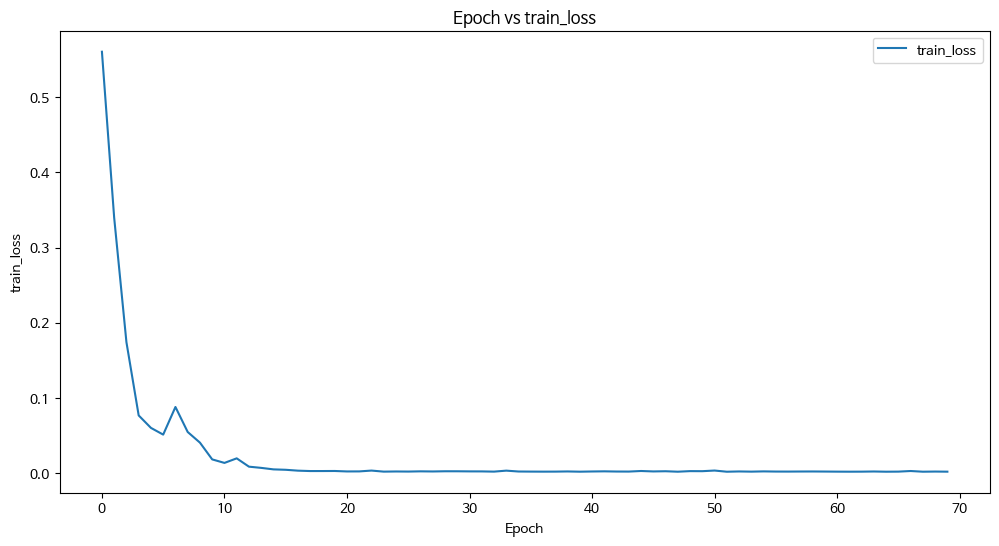

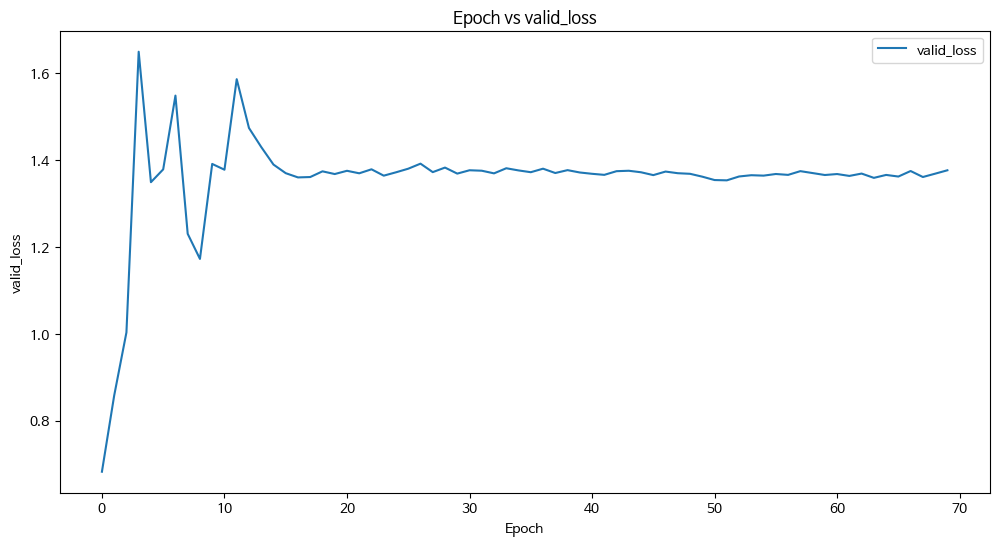

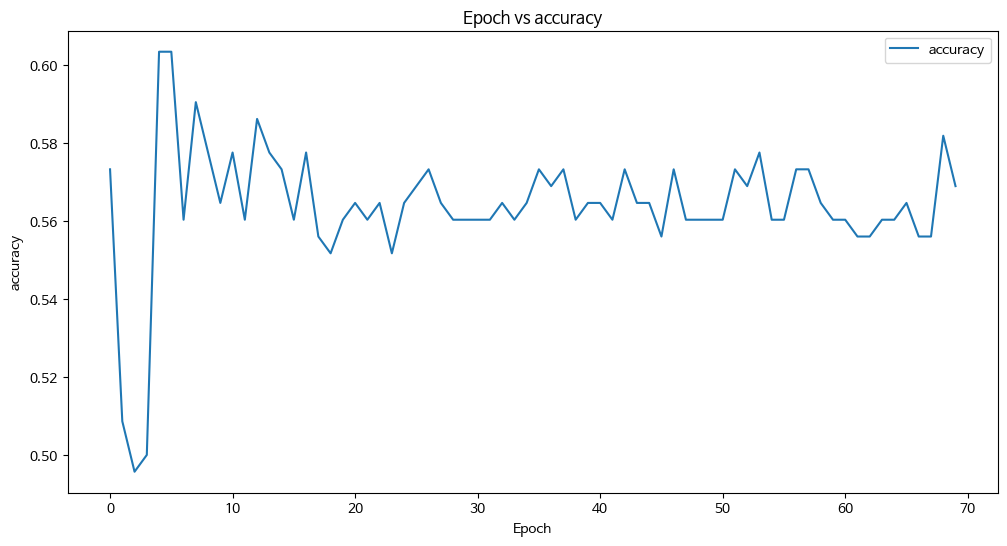

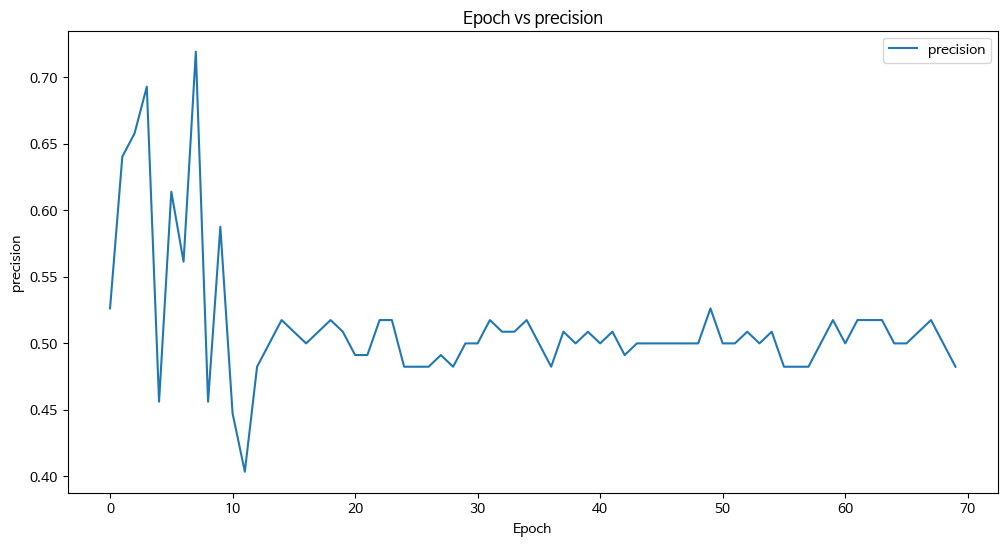

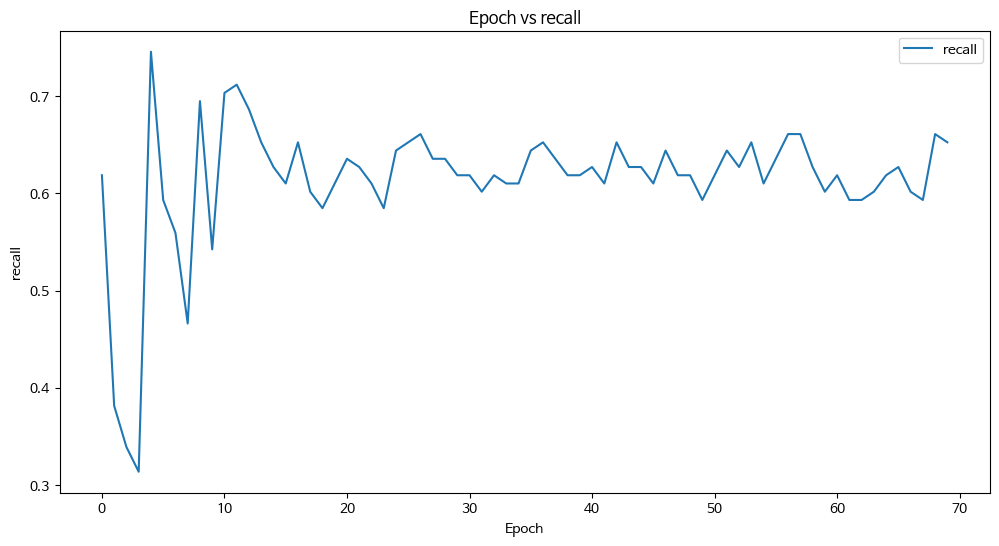

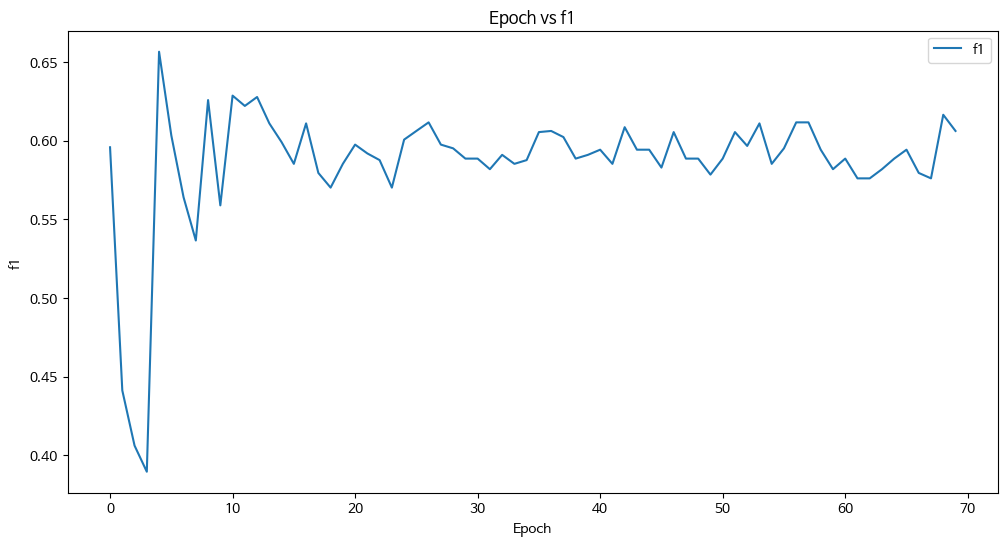

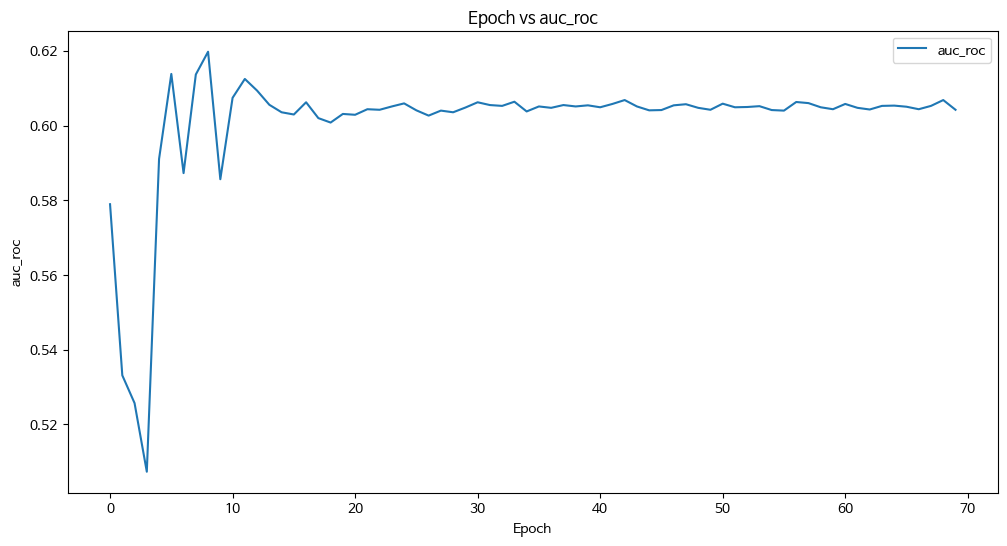

In [ ]:
# 1단계: 필요한 라이브러리와 모듈을 가져옵니다.
import json
import pandas as pd
import matplotlib.pyplot as plt

# 2단계: 로그 파일을 읽습니다.
log_data = []
# with open('/content/log.txt', 'r') as log_file:
with open('/content/drive/MyDrive/Med_ChatGPT_tutorial_Dataset/230701_ResNet50_Base/log.txt', 'r') as log_file:
    for line in log_file:
        log_data.append(json.loads(line))
log_df = pd.DataFrame(log_data)

# 3단계: 손실에 대해 오름차순으로 5개의 값을 출력합니다.
print(log_df.sort_values('valid_loss')[:5])

# 4단계: 평가 지표에 대해 내림차순으로 5개의 값을 출력합니다.
print(log_df.sort_values('accuracy', ascending=False)[:5])
print(log_df.sort_values('precision', ascending=False)[:5])
print(log_df.sort_values('recall', ascending=False)[:5])
print(log_df.sort_values('f1', ascending=False)[:5])
print(log_df.sort_values('auc_roc', ascending=False)[:5])

# 5단계: 각 변수에 대해 그래프를 그립니다.
metrics = ['train_loss', 'valid_loss', 'accuracy', 'precision', 'recall', 'f1', 'auc_roc']
for metric in metrics:
    plt.figure(figsize=(12,6))
    plt.plot(log_df[metric], label=metric)
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend(loc='upper right')
    plt.title(f'Epoch vs {metric}')
    plt.show()


## 2. Test Dataset

In [ ]:
class RSNA_Test_Dataset(Dataset):
    def __init__(self, csv_file, mode):
        # csv 파일 읽기
        self.dataframe = pd.read_csv(csv_file)
        # 초기 단계에서 'mode'에 따라 데이터 프레임 필터링
        self.dataframe = self.dataframe[self.dataframe['mode'] == mode]
        self.transform = Compose([
            Resize(224, 224),
            ToTensorV2()
          ])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # 이미지 파일 경로 읽기
        img_path = self.dataframe.iloc[idx, self.dataframe.columns.get_loc('path')]
        # DICOM 파일 읽기
        dicom = pydicom.dcmread(img_path)
        # LUT 적용
        img = dicom.pixel_array
        img = img * dicom.RescaleSlope + dicom.RescaleIntercept
        # 이미지 Augmentation
        img = self.transform(image=img)['image']
        # Min-Max 정규화 (Augmentation 이후에 적용)
        img = (img - torch.min(img)) / (torch.max(img) - torch.min(img))

        # 라벨 정보 읽기
        label = self.dataframe.iloc[idx, self.dataframe.columns.get_loc('cancer')]
        # 라벨을 텐서로 변환
        label = torch.tensor(label, dtype=torch.float32)

        return img, label


# TEST 데이터셋 생성
test_dataset = RSNA_Test_Dataset(csv_file="/content/drive/MyDrive/Med_ChatGPT_tutorial_Dataset/rsna_data.csv", mode="test")

# DataLoader 설정
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

## 3. Load Checkpoint

In [ ]:
# Metric  =  accuracy
# Argsort =  [ 4  5  7 12 68]
# Value   =  [0.60344828 0.60344828 0.59051724 0.5862069  0.58189655]

# filename = '/content/Med_ChatGPT_tutorial/checkpoints/230701_ResNet50_Base'
filename = '/content/drive/MyDrive/Med_ChatGPT_tutorial_Dataset/230701_ResNet50_Base/epoch_4_checkpoint.pth'

print("=> loading checkpoint '{}'".format(filename))
checkpoint  = torch.load(filename)
model.load_state_dict(checkpoint['model_state_dict'])

=> loading checkpoint '/content/drive/MyDrive/Med_ChatGPT_tutorial_Dataset/230701_ResNet50_Base/epoch_4_checkpoint.pth'


<All keys matched successfully>

## 4. Using GPU testing

In [ ]:
# using CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

## 5. Test Loop

In [ ]:
# Grad-CAM(Gradient-weighted Class Activation Mapping)은 딥러닝 모델의 클래스 관련 특징 맵을 시각화하는 기법입니다.

# 이 기법은 주어진 입력 이미지에서 모델이 특정 클래스에 집중하는 부분을 시각적으로 파악할 수 있게 해줍니다.

  0%|          | 0/232 [00:00<?, ?it/s]

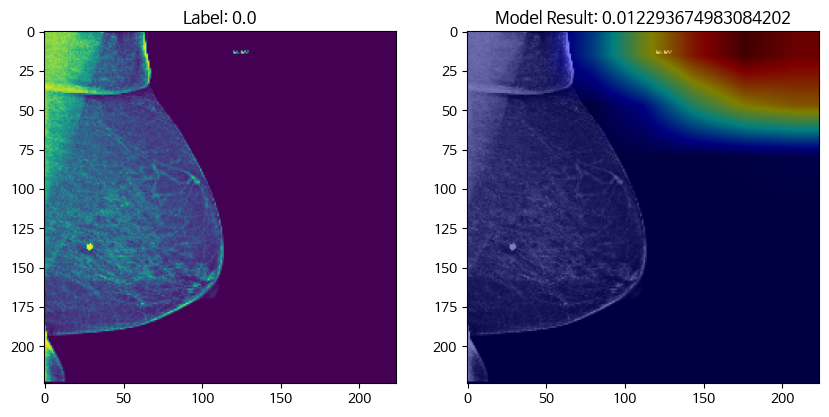

  0%|          | 1/232 [00:04<16:37,  4.32s/it]

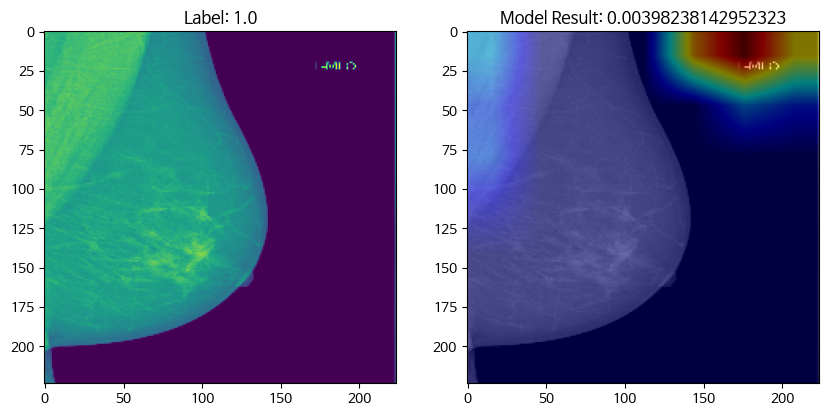

  1%|          | 2/232 [00:04<08:09,  2.13s/it]

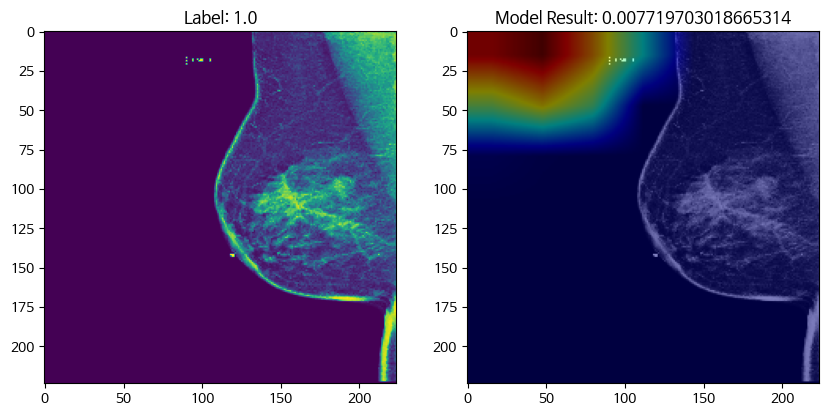

  1%|▏         | 3/232 [00:07<09:20,  2.45s/it]

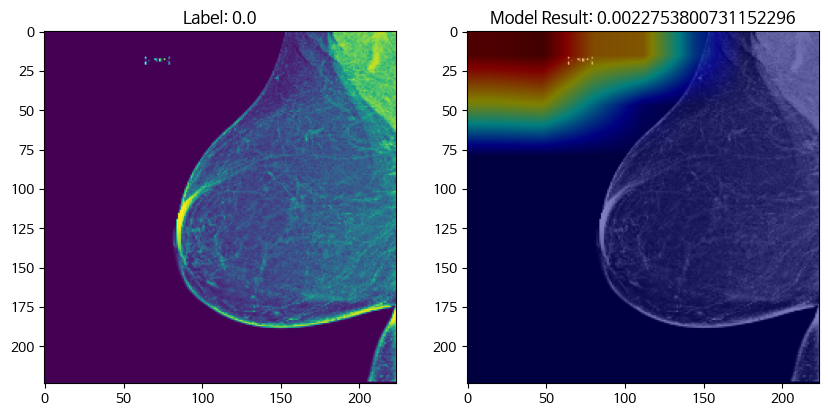

  2%|▏         | 4/232 [00:08<06:33,  1.72s/it]

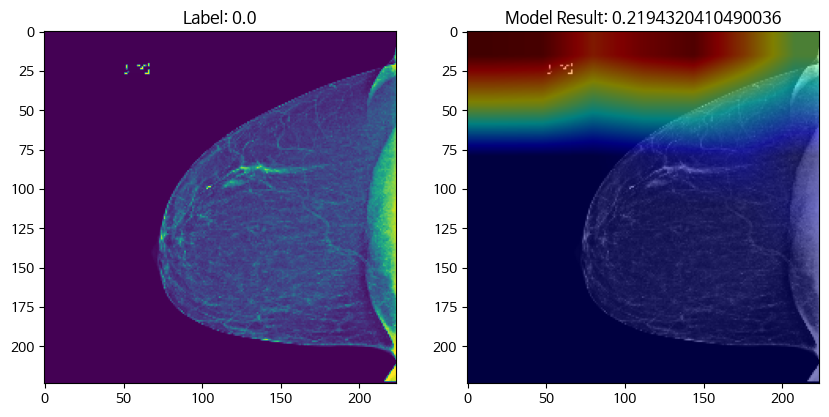

  2%|▏         | 5/232 [00:10<06:44,  1.78s/it]

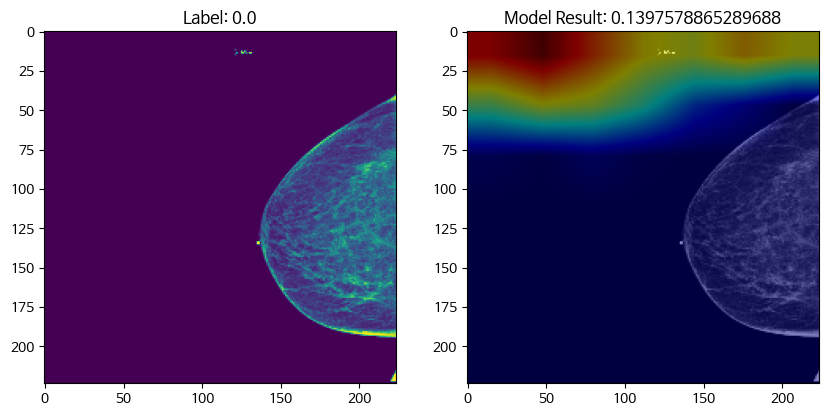

  3%|▎         | 6/232 [00:15<09:35,  2.55s/it]


KeyboardInterrupt: ignored

In [ ]:
# 완성

# 필요한 라이브러리를 설치합니다.
!pip install pytorch-gradcam

# 필요한 라이브러리를 가져옵니다.
from gradcam.utils import visualize_cam
from gradcam import GradCAMpp, GradCAM
import time

# test_loop_fn를 수정하고 Grad-CAM 시각화를 추가합니다.
def test_loop_fn(loader, model, device):
    model.eval()
    outputs, targets = [], []
    start_time = time.time()

    # 마지막 컨볼루션 레이어의 Grad-CAM을 설정합니다.
    grad_cam = GradCAM(model, model.model.layer4)

    pbar = tqdm(loader, total=len(loader))
    for i, (image, target) in enumerate(pbar):
        image = image.float().to(device)
        target = target.float().unsqueeze(1).to(device)

        output = model(image)

        # Grad-CAM 마스크를 생성합니다.
        mask, _ = grad_cam(image)
        heatmap, result = visualize_cam(mask, image)

        outputs.append(output.detach().cpu())
        targets.append(target.detach().cpu())

        # 원본 이미지와 Grad-CAM 결과를 함께 출력합니다.
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image.cpu().squeeze().numpy())
        plt.title(f"Label: {target.item()}")

        plt.subplot(1, 2, 2)
        plt.imshow(result.cpu().squeeze().numpy().transpose(1, 2, 0))
        plt.title(f"Model Result: {output.sigmoid().item()}")

        plt.show()

    outputs = torch.stack(outputs).squeeze().sigmoid()
    targets = torch.stack(targets).squeeze().numpy()

    accuracy, precision, recall, f1, auc_roc = calculate_metrics(target=targets, prediction=outputs.round().numpy(), prob=outputs.numpy())
    metrics = {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1, "auc_roc": auc_roc}

    print(f"Test Metrics: {metrics}")

    # 시간을 측정하고 출력합니다.
    end_time = time.time()
    print(f"Total test time: {end_time - start_time} seconds")

# test_loop_fn를 실행합니다.
test_loop_fn(test_loader, model, device)


In [ ]:
# 결과 정리

In [ ]:
'test_auc'       : 0.5961938745168004,
'test_accuracy'   : 0.5948275862068966,
'test_f1'         : 0.626984126984127,
'test_sensitivity': 0.6694915254237288,
'test_specificity': 0.5175438596491229
